In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import plot

In [2]:
N_RUNS = 20

In [3]:
dataset = "gene_expression"

method1 = "mu-standard2000"
method2 = "mu-jointnorm1"

X = np.load(f"../data/{dataset}.npy")
X.shape

(1838, 2638)

In [4]:
# plot
title = "Gene expression"
outpath = f"../plots/{dataset}_{method1}_{method2}"

xtickslabels = ["standard", "joint"]

Each saved history from an NMF run is stored as a dictionary:

* Keys: iteration numbers
* Values: tuples of (objective‑function value, runtime) for each iteration

In [5]:
def get_n_iterations(history: dict[int, (float, float)]) -> int:
    """
    Get the number of iterations until convergence.
    """
    return np.sort(list(history.keys()))[-1]


def get_runtime(history: dict[int, (float, float)]) -> float:
    """
    Get the total runtime until convergence from the saved history.
    """
    n_iter = get_n_iterations(history)
    runtime = history[n_iter][1]
    return runtime


def get_objective_function_value(history: dict[int, (float, float)]) -> float:
    """
    Get the final objective-function value from the saved history.
    """
    n_iter = get_n_iterations(history)
    final_of_value = history[n_iter][0]
    return final_of_value

In [6]:
with open(f"../results/{method1}/{dataset}/histories.pkl", "rb") as f:
    histories1 = pickle.load(f)

with open(f"../results/{method2}/{dataset}/histories.pkl", "rb") as f:
    histories2 = pickle.load(f)


n_iterations1 = np.array([get_n_iterations(history) for history in histories1])
runtimes1 = np.array([get_runtime(history) for history in histories1])
of_values1 = np.array([get_objective_function_value(history) for history in histories1])

n_iterations2 = np.array([get_n_iterations(history) for history in histories2])
runtimes2 = np.array([get_runtime(history) for history in histories2])
of_values2 = np.array([get_objective_function_value(history) for history in histories2])

In [7]:
def adjust_of_values_get_factor(X: np.ndarray) -> float:
    """
    Adjust objective function values following Section 5.1 of
    "Algorithms for Nonnegative Matrix Factorization with
    the Kullback-Leibler Divergence", 2021 by
    Le Thi Khanh Hien and Nicolas Gillis
    """
    V, D = X.shape
    averages = X.sum(axis=1) / D
    factor = 0.0
    for v in range(V):
        for d in range(D):
            c = X[v, d]
            if c != 0:
                factor += c * np.log(c / averages[v])
    return factor


def adjust_of_values(
    X: np.ndarray, of_values: np.ndarray, factor: float | None = None
) -> np.ndarray:
    """
    Adjust objective function values following Section 5.1 of
    "Algorithms for Nonnegative Matrix Factorization with
    the Kullback-Leibler Divergence", 2021 by
    Le Thi Khanh Hien and Nicolas Gillis
    """
    if factor is None:
        factor = adjust_of_values_get_factor(X)

    return np.array(of_values) / factor

In [8]:
factor = adjust_of_values_get_factor(X)
of_values1 = adjust_of_values(X, of_values1, factor=factor)
of_values2 = adjust_of_values(X, of_values2, factor=factor)
best_rel_of_value = np.min(np.concatenate([of_values1, of_values2]))
of_values1 -= best_rel_of_value
of_values2 -= best_rel_of_value

In [9]:
of_values1

array([0.00024327, 0.0005856 , 0.00087162, 0.00545395, 0.00159602,
       0.00142329, 0.00074142, 0.00041224, 0.0008955 , 0.00057501,
       0.00087911, 0.00076848, 0.00046482, 0.00097287, 0.00149192,
       0.00041419, 0.00192845, 0.00032226, 0.00083578, 0.0014531 ])

# Boxplot

In [10]:
update_rules = np.concatenate([np.full(N_RUNS, method1), np.full(N_RUNS, method2)])
times = np.concatenate([runtimes1, runtimes2])
of_values = np.concatenate([of_values1, of_values2])
ns_iterations = np.concatenate([n_iterations1, n_iterations2])
empty = np.empty(2 * N_RUNS, dtype=str)
ys = ["CPU time (in s)", "objective", "n_iterations"]

data = pd.DataFrame(
    list(zip(empty, update_rules, times, of_values, ns_iterations)),
    columns=[
        "placeholder",
        "update rule",
        "CPU time (in s)",
        "objective",
        "n_iterations",
    ],
)
data.head()

,placeholder,update rule,CPU time (in s),objective,n_iterations
0,,mu-standard2000,73.164765,0.000243,720
1,,mu-standard2000,73.870223,0.000586,740
2,,mu-standard2000,78.128048,0.000872,770
3,,mu-standard2000,68.684058,0.005454,690
4,,mu-standard2000,113.034404,0.001596,1110


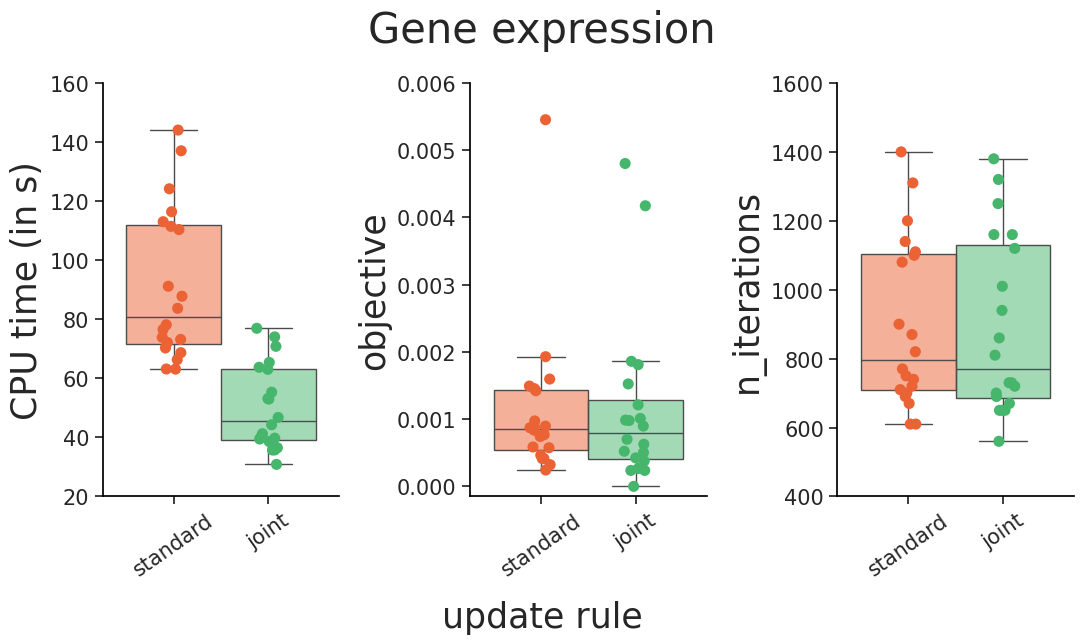

In [11]:
ys = ["CPU time (in s)", "objective", "n_iterations"]

fig, axes = plt.subplots(1, 3, figsize=(11, 6))
fig.suptitle(f"{title}", fontsize=30)

for (
    y,
    ax,
) in zip(ys, axes):
    plot.boxplot(
        data=data,
        x="placeholder",
        y=y,
        hue="update rule",
        palette=plot.COLORS,
        dashed_lines=False,
        ax=ax,
        kwargs_boxplot={"rotation": 90},
        kwargs_stripplot={"s": 8},
    )
    ax.set_xticks([-0.2, 0.2])
    ax.set_xticklabels(xtickslabels, rotation=35, fontsize=15)
    ax.ticklabel_format(style="plain", axis="y")
    ax.set_yticks(ax.get_yticks())
    ax.set_xlabel("")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(bottom=max(0, ymin))
    ax.set_ylabel(ax.get_ylabel(), fontsize=25)
    ax.get_legend().remove()

axes[1].set_ylim(-0.025 * axes[1].get_ylim()[1], axes[1].get_ylim()[1])
fig.text(0.5, -0.05, "update rule", ha="center", fontsize=25)
plt.subplots_adjust(wspace=1.5)
plt.tight_layout()
# plt.savefig(f"{outpath}_boxplot.pdf", bbox_inches="tight")

## mean and standard deviation

In [12]:
means = data.groupby("update rule")[ys].mean()
means

,CPU time (in s),objective,n_iterations
update rule,,,
mu-jointnorm1,50.214692,0.001157,888.0
mu-standard2000,91.232777,0.001116,895.0


In [13]:
stds = data.groupby("update rule")[ys].std()
stds

,CPU time (in s),objective,n_iterations
update rule,,,
mu-jointnorm1,14.327524,0.001254,257.898389
mu-standard2000,25.603726,0.001123,243.623955


In [14]:
from decimal import Decimal

"%.2E" % Decimal(means["objective"].iloc[0])

'1.16E-03'

In [15]:
"%.2E" % Decimal(stds["objective"].iloc[0])

'1.25E-03'

# History plot

## x-axis: number of iterations

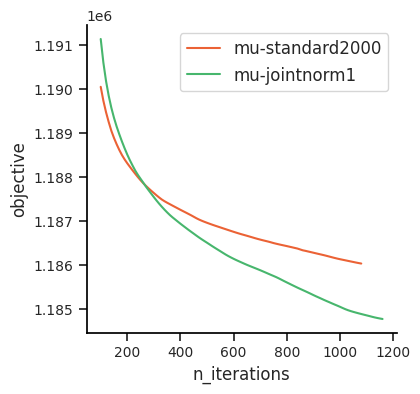

In [16]:
# sanity check
n_run = np.random.choice(np.arange(N_RUNS))
n_skip = 10

history1 = np.array([v[0] for v in histories1[n_run].values()])
history2 = np.array([v[0] for v in histories2[n_run].values()])
history1 = history1[n_skip:]
history2 = history2[n_skip:]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# 10 is the default frequency at which objective function values are computed
ax.plot(
    10 * n_skip + 10 * np.arange(len(history1)),
    history1,
    label=method1,
    color=plot.COLORS[0],
)
ax.plot(
    10 * n_skip + 10 * np.arange(len(history2)),
    history2,
    label=method2,
    color=plot.COLORS[1],
)
ax.set_xlabel("n_iterations")
ax.set_ylabel("objective")
ax.legend()

## x-axis: time

In [17]:
from matplotlib.pyplot import Axes
from scipy.interpolate import interp1d

In [18]:
def get_times(history: dict[int, (float, float)]) -> np.ndarray:
    return np.array([v[1] for v in history.values()])


def get_of_values(history: dict[int, (float, float)]) -> np.ndarray:
    return np.array([v[0] for v in history.values()])


def unify_grid(
    all_times: list,
    all_of_values: list,
    t_cutoff: float | None = None,
) -> [np.ndarray, np.ndarray]:
    tmin = min(times[0] for times in all_times)
    tmin = max([tmin, t_cutoff])
    tmax = min(times[-1] for times in all_times)
    t_grid = np.linspace(tmin, tmax, int(10 * (tmax - tmin)))
    unified_of_values = np.zeros((len(all_of_values), len(t_grid)))

    for i, (times, of_values) in enumerate(zip(all_times, all_of_values)):
        f = interp1d(times, of_values, kind="linear", bounds_error=False)
        unified_of_values[i] = f(t_grid)

    return t_grid, unified_of_values


def plot_unified_history(
    all_times: list,
    all_of_values: list,
    t_cutoff: float | None = None,
    ax: Axes | None = None,
    color: str | None = None,
    **kwargs,
) -> None:
    t_grid, unified_of_values = unify_grid(all_times, all_of_values, t_cutoff)
    mean = np.nanmean(unified_of_values, axis=0)
    std = np.nanstd(unified_of_values, axis=0)
    lower = mean - std
    upper = mean + std

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    ax.plot(t_grid, mean, color=color, **kwargs)
    ax.fill_between(t_grid, lower, upper, color=color, alpha=0.3)
    ax.set_xlabel("time (in s)")
    ax.set_ylabel("objective")

In [19]:
all_times1 = [get_times(history) for history in histories1]
all_of_values1 = [get_of_values(history) for history in histories1]
all_of_values1 = [
    adjust_of_values(X, of_values, factor=factor) - best_rel_of_value
    for of_values in all_of_values1
]

all_times2 = [get_times(history) for history in histories2]
all_of_values2 = [get_of_values(history) for history in histories2]
all_of_values2 = [
    adjust_of_values(X, of_values, factor=factor) - best_rel_of_value
    for of_values in all_of_values2
]

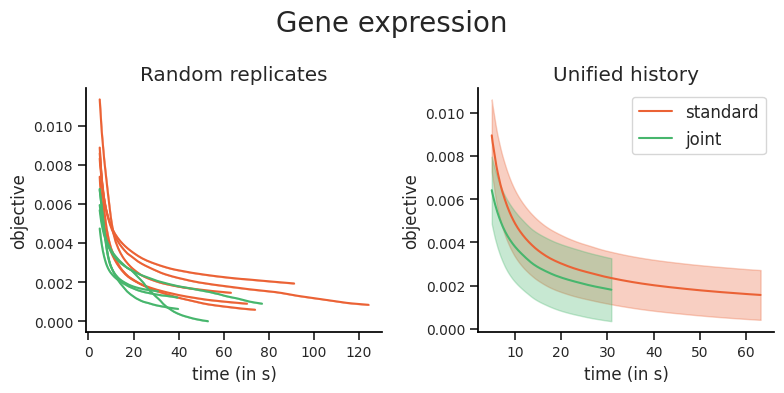

In [20]:
n_replicates = 5
replicates = np.random.choice(20, 5, replace=False)
selected_times1 = [all_times1[r] for r in replicates]
selected_of_values1 = [all_of_values1[r] for r in replicates]
selected_times2 = [all_times2[r] for r in replicates]
selected_of_values2 = [all_of_values2[r] for r in replicates]
label1 = "standard"
label2 = "joint"
t_cutoff = 5

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(title, fontsize=20)
axes[0].set_title("Random replicates")
axes[1].set_title("Unified history")

for times, of_values in zip(selected_times1, selected_of_values1):
    plot_unified_history(
        [times], [of_values], t_cutoff=t_cutoff, ax=axes[0], color=plot.COLORS[0]
    )

for times, of_values in zip(selected_times2, selected_of_values2):
    plot_unified_history(
        [times], [of_values], t_cutoff=t_cutoff, ax=axes[0], color=plot.COLORS[1]
    )

plot_unified_history(
    all_times1,
    all_of_values1,
    t_cutoff=t_cutoff,
    ax=axes[1],
    label=label1,
    color=plot.COLORS[0],
)
plot_unified_history(
    all_times2,
    all_of_values2,
    t_cutoff=t_cutoff,
    ax=axes[1],
    label=label2,
    color=plot.COLORS[1],
)
axes[1].legend()
plt.tight_layout()
# plt.savefig(f"{outpath}_lineplot.pdf", bbox_inches="tight")